In [1]:
# For display of example images
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
# To do the bulk of the work for us, data manipulation and image control
import numpy as np
import cv2
# To grab image directories
import glob
# To measure processing times
import time
# To create and train the model used for predictions
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from skimage.feature import hog
# To hold the functions created for this project
from featureprocesser import *

### Load, if available

In [2]:
import pickle
X_train = pickle.load( open( "./data/saved/X_train.p", "rb" ) )
X_test = pickle.load( open( "./data/saved/X_test.p", "rb" ) )
y_train = pickle.load( open( "./data/saved/y_train.p", "rb" ) )
y_test = pickle.load( open( "./data/saved/y_test.p", "rb" ) )
X_scaler = pickle.load( open( "./data/saved/X_scaler.p", "rb"))
svc = pickle.load( open( "./data/saved/classifier.p", "rb" ) )

## Image directories

In [3]:
# Read in non-car image locations
notcars = glob.glob('./data/examples/non-vehicles/*.png')
# Read in car image locations
cars = glob.glob('./data/examples/vehicles/*.png')

In [ ]:
carstack = mpimg.imread("./data/examples/carstack.png")
notcarstack = mpimg.imread("./data/examples/notcarstack.png")
# Example images
plt.imshow(carstack)
plt.show()
plt.imshow(notcarstack)
plt.show()

## Feature extraction

In [ ]:
# Car image directories are turned into a feature list 
# Defaults as set are to use the color histogram and all three channels of Ycrcb as Hog, with 8 directions not 9. 
car_features = extract_features(cars)
notcar_features = extract_features(notcars)

In [ ]:
# Create an array stack of feature vectors
allfeatures = np.vstack((car_features, notcar_features)).astype(np.float64)
# Fit a per-column scaler
X_scaler = StandardScaler().fit(allfeatures)
# Apply the scaler to allfeatures to get scaledfeatures
scaledfeatures = X_scaler.transform(allfeatures)

In [ ]:
# For each car: one. Not car: zero. These are the correct predictions for all of the dataset. 
featureanswers = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

In [ ]:
# Split up data into randomized training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    scaledfeatures, featureanswers, test_size=0.2)

In [ ]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

In [ ]:
import pickle
#Save
pickle.dump( X_train, open( "./data/saved/X_train.p", "wb" ) )
pickle.dump( X_test, open( "./data/saved/X_test.p", "wb" ) )
pickle.dump( y_train, open( "./data/saved/y_train.p", "wb" ) )
pickle.dump( y_test, open( "./data/saved/y_test.p", "wb" ) )
pickle.dump( X_scaler, open( "./data/saved/X_scaler.p", "wb"))

## SVC training

In [4]:
# Use a linear SVC / Using hinge reduced training times by a third and increased accuracy by 1.2%.
# Other settings only hurt performance.
svc = LinearSVC(loss='hinge')

# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()

print(round(t2-t, 2), 'Seconds to train SVC...')

7.86 Seconds to train SVC...


In [5]:
print('Train Accuracy: ',svc.score(X_train, y_train), 'Test Accuracy: ', svc.score(X_test, y_test))

Train Accuracy:  1.0 Test Accuracy:  0.990334906721


In [6]:
# Check the prediction time for ten samples
t=time.time()
print('My SVC predicts:     ', svc.predict(X_test[20:30]))
print('For these',10, 'labels: ', y_test[20:30])
t2 = time.time()

print(round(t2-t, 5), 'Seconds to predict', 10,'labels with SVC')

My SVC predicts:      [ 1.  1.  0.  0.  1.  1.  0.  0.  1.  1.]
For these 10 labels:  [ 1.  1.  0.  0.  1.  1.  0.  0.  1.  1.]
0.00544 Seconds to predict 10 labels with SVC


In [ ]:
pickle.dump( svc, open( "./data/saved/classifier.p", "wb" ) )

## Image seach using svc | skip to here if loaded

In [7]:
# Choose an image to test on
image = cv2.imread('data/test_images/test5.jpg')

In [8]:
global bboxes

bboxes = sliding_windows(image, x_start_stop=[None, None], y_start_stop=[400, 500], 
                                xy_window=[64, 64], xy_overlap=[0.5, 0.5])

bboxes += sliding_windows(image, x_start_stop=[None, None], y_start_stop=[400, 550], 
                                xy_window=[96, 96], xy_overlap=[0.5, 0.5])

bboxes += sliding_windows(image, x_start_stop=[None, None], y_start_stop=[400, 600], 
                          xy_window=[128, 128], xy_overlap=[0.5, 0.5])

len(bboxes)

166

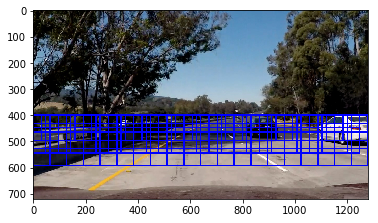

In [9]:
plt.imshow(draw_boxes(cv2.cvtColor(image,cv2.COLOR_BGR2RGB),bboxes))
plt.show()

In [10]:
features = []
  
for box in bboxes:

    # Use array slicing to get the image in a box
    # Then resize to (64, 64) for all images.
    sliced_image = image[box[0][1]:box[1][1], box[0][0]:box[1][0]]
    resized_image = cv2.resize(sliced_image, (64, 64))  

    # For each image, extract features, save to list of features.
    features.append(single_img_features(resized_image))



In [11]:
features = np.array(features)

In [12]:
features[0].shape

(7776,)

In [13]:
# Scale the features, then run them through the SVM
# Save the positive predictions in a list.
# Apply the scaler to allfeatures to get scaledfeatures
scaledfeatures = X_scaler.transform(features)

predictions = svc.predict(scaledfeatures)


In [14]:
detected = []

for i in range(len(bboxes)):
    if predictions[i] == 1:
        detected.append(bboxes[i])

In [15]:
heatmap = np.zeros_like(image[:,:,0])

In [16]:
heatmap = add_heat(heatmap, detected)

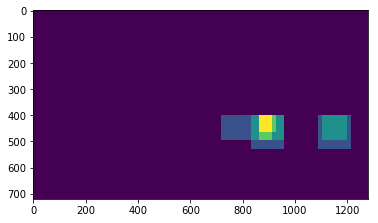

In [17]:
plt.imshow(heatmap)
plt.show()

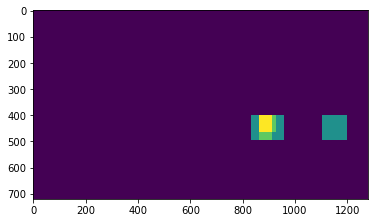

In [18]:
plt.imshow(apply_threshold(heatmap, 2))
plt.show()

2 cars found


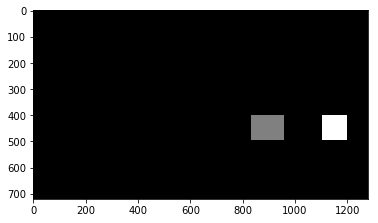

In [19]:
from scipy.ndimage.measurements import label
labels = label(heatmap)
heatmap = apply_threshold(heatmap, 2)
labels = label(heatmap)
print(labels[1], 'cars found')
plt.imshow(labels[0], cmap='gray')
plt.show()

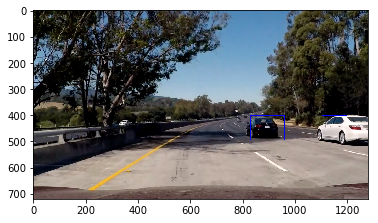

In [20]:
plt.imshow(draw_labeled_boxes(cv2.cvtColor(image,cv2.COLOR_BGR2RGB), labels))
plt.show()

In [21]:
from sklearn.externals import joblib
from scipy.ndimage.measurements import label

# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [22]:
global pastframes
pastframes = []
def car_detector(image):

    image = cv2.cvtColor(image,cv2.COLOR_RGB2BGR)

    features = []
    for box in bboxes:
        # Use array slicing to get the image in a box
        # Then resize to (64, 64) for all images.
        sliced_image = image[box[0][1]:box[1][1], box[0][0]:box[1][0]]
        resized_image = cv2.resize(sliced_image, (64, 64))  

        # For each image, extract features, save to list of features.
        features.append(single_img_features(resized_image))

    
    # Scale the features, then run them through the SVM
    # Save the positive predictions in a list.   
    features = np.array(features)
    scaled_features = X_scaler.transform(features)
    predictions = svc.predict(scaled_features)

    detected = []
    for i in range(len(predictions)):
        if predictions[i] == 1:
            detected.append(bboxes[i])

    #Add all detections to the heatmap, then trim one off detections.
    heatmap = np.zeros_like(image[:,:,0])

    heatmap = add_heat(heatmap, detected)
    heatmap = apply_threshold(heatmap, 2)
    labels = label(heatmap)

    # If it passed detection for one frame, add to the frame buffer
    pastframes.append(calculate_labeled_boxes(image, labels))
    if len(pastframes) > 10:
        pastframes.pop(0)

        # Use the frame buffer to create the finished box
        for frame in pastframes:
            heatmap = add_heat(heatmap, frame)    

        heatmap = apply_threshold(heatmap, 8)
        labels = label(heatmap)
        
        
    image = draw_labeled_boxes(cv2.cvtColor(image, cv2.COLOR_BGR2RGB), labels)
        
    return image

In [25]:
vid_output = './data/SVC_video.mp4'
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(vid_output))

In [23]:
vid_output = 'project_video_out.mp4'
clip = VideoFileClip('./data/test_videos/project_video.mp4')

In [ ]:
vid_clip = clip.fl_image(lambda x: car_detector(x))
vid_clip.write_videofile(vid_output, audio=False)